Phase 1

1. Installing necessary libraries


In [ ]:
import os
import json
import random
import numpy as np
import pandas as pd
from pathlib import Path
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

2. Load and Verify Dataset Structure

In [5]:
class VQADatasetLoader:
    
    def __init__(self, base_path):
        self.base_path = Path(base_path)
        self.validate_structure()
        
    def validate_structure(self):
        required_folders = ['train_images', 'val_images', 'annotations']
        
        print("Dataset structure:")
        for folder in required_folders:
            folder_path = self.base_path / folder
            if folder_path.exists():
                item_count = len(list(folder_path.glob('*')))
                print(f" {folder}: {item_count} items")
            else:
                print(f" Missing folder: {folder}")
                raise FileNotFoundError(f"Missing folder: {folder}")
    
    def load_json_file(self, file_path):
        full_path = self.base_path / file_path
        if not full_path.exists():
            raise FileNotFoundError(f"File not found: {full_path}")
        
        with open(full_path, 'r') as f:
            data = json.load(f)
        return data

# Initialize dataset loader
dataset_path = "VQA_Project_10k"
image_base_path = "VQA_Project_10k"  
print(f" Dataset path: {dataset_path}")

try:
    loader = VQADatasetLoader(dataset_path)
    print(" Dataset structure validated")
except Exception as e:
    print(f" Error: {e}")
    print(" Creating directory structure:")
    os.makedirs(dataset_path, exist_ok=True)
    os.makedirs(os.path.join(dataset_path, 'train_images'), exist_ok=True)
    os.makedirs(os.path.join(dataset_path, 'val_images'), exist_ok=True)
    os.makedirs(os.path.join(dataset_path, 'annotations'), exist_ok=True)
    loader = VQADatasetLoader(dataset_path)


 Dataset path: VQA_Project_10k
Dataset structure:
 train_images: 9920 items
 val_images: 3000 items
 annotations: 6 items
 Dataset structure validated


3. Load Annotations and Questions 

In [6]:
def load_vqa_data(loader):
    dataset = {}
    
    train_files = ['vqa_train_questions.json', 'vqa_train_annotations.json']
    
    for i in range(2): 
        try:
            if i == 0:
                train_q = loader.load_json_file(f'annotations/{train_files[0]}')
                train_a = loader.load_json_file(f'annotations/{train_files[1]}')
            else:
                annotation_files = list((loader.base_path / 'annotations').glob('*.json'))
                train_q_files = [f for f in annotation_files if 'train' in f.name.lower() and 'question' in f.name.lower()]
                train_a_files = [f for f in annotation_files if 'train' in f.name.lower() and 'annotation' in f.name.lower()]
                
                if train_q_files and train_a_files:
                    train_q = loader.load_json_file(f'annotations/{train_q_files[0].name}')
                    train_a = loader.load_json_file(f'annotations/{train_a_files[0].name}')
                else:
                    continue
            
            dataset['train'] = {'questions': train_q, 'annotations': train_a}
            print(f" Training data loaded")
            break
        except Exception as e:
            if i == 0:
                print(f" Could not load exact training files: {e}")
            else:
                print(f" Could not find training data")
                dataset['train'] = None
    
    # Try to load validation data
    val_files = ['vqa_val_questions.json', 'vqa_val_annotations.json']
    
    for i in range(2):
        try:
            if i == 0:
                # Try exact filenames
                val_q = loader.load_json_file(f'annotations/{val_files[0]}')
                val_a = loader.load_json_file(f'annotations/{val_files[1]}')
            else:
                # Try to find any validation files
                annotation_files = list((loader.base_path / 'annotations').glob('*.json'))
                val_q_files = [f for f in annotation_files if 'val' in f.name.lower() and 'question' in f.name.lower()]
                val_a_files = [f for f in annotation_files if 'val' in f.name.lower() and 'annotation' in f.name.lower()]
                
                if val_q_files and val_a_files:
                    val_q = loader.load_json_file(f'annotations/{val_q_files[0].name}')
                    val_a = loader.load_json_file(f'annotations/{val_a_files[0].name}')
                else:
                    continue
            
            dataset['val'] = {'questions': val_q, 'annotations': val_a}
            print(f" Validation data loaded")
            break
        except Exception as e:
            if i == 0:
                print(f" Could not load exact validation files: {e}")
            else:
                print(f" Could not find validation data")
                dataset['val'] = None
    
    return dataset

# Load the dataset
dataset = load_vqa_data(loader)

 Training data loaded
 Validation data loaded


4. Create DataFrames from Loaded Data

In [7]:
def create_dataframe_from_vqa(data_dict, split_name='train'):
    if data_dict is None:
        print(f" No data for {split_name} split")
        return None
    
    try:
        questions = data_dict.get('questions', {}).get('questions', [])
        annotations = data_dict.get('annotations', {}).get('annotations', [])
        
        if not questions and not annotations:
            print(f" No valid data found for {split_name}")
            return None
        
        print(f"  Processing {split_name}: {len(questions)} questions, {len(annotations)} annotations")
        
        q_dict = {q['question_id']: q for q in questions if 'question_id' in q}
        a_dict = {a['question_id']: a for a in annotations if 'question_id' in a}
        
        
        data = []
        for qid in set(list(q_dict.keys()) + list(a_dict.keys())):
            row = {'question_id': qid, 'split': split_name}
            
            if qid in q_dict:
                q = q_dict[qid]
                row['image_id'] = q.get('image_id', 0)
                row['question'] = q.get('question', '')
            
            if qid in a_dict:
                a = a_dict[qid]
                row['question_type'] = a.get('question_type', 'unknown')
                row['answer_type'] = a.get('answer_type', 'unknown')
                row['multiple_choice_answer'] = a.get('multiple_choice_answer', '')
                row['answers'] = [ans.get('answer', '') for ans in a.get('answers', [])]
            
            # Add missing fields if not present
            for field in ['image_id', 'question', 'question_type', 'answer_type', 
                         'multiple_choice_answer', 'answers']:
                if field not in row:
                    row[field] = 0 if field == 'image_id' else '' if field != 'answers' else []
            
            data.append(row)
        
        df = pd.DataFrame(data)
        print(f" Created {split_name} DataFrame with {len(df)} rows")
        return df
        C
    except Exception as e:
        print(f" Error creating {split_name} DataFrame: {e}")
        return None

# Create DataFrames
train_df = create_dataframe_from_vqa(dataset.get('train'), 'train')
val_df = create_dataframe_from_vqa(dataset.get('val'), 'val')

# Show basic info
if train_df is not None:
    print(f"\n  Training DataFrame shape: {train_df.shape}")
    print(f"  Columns: {train_df.columns.tolist()}")
    
if val_df is not None:
    print(f"\n  Validation DataFrame shape: {val_df.shape}")

  Processing train: 49760 questions, 49760 annotations
 Created train DataFrame with 49760 rows
  Processing val: 15571 questions, 15571 annotations
 Created val DataFrame with 15571 rows

  Training DataFrame shape: (49760, 8)
  Columns: ['question_id', 'split', 'image_id', 'question', 'question_type', 'answer_type', 'multiple_choice_answer', 'answers']

  Validation DataFrame shape: (15571, 8)


5. Create Data Split

In [8]:
def create_train_val_splits(train_df, val_df, val_size=0.2):
    
    if train_df is None or len(train_df) == 0:
        print(" No training data available")
        return None, None
    
    if val_df is not None and len(val_df) > 0:
        print(f" Using provided validation data: {len(val_df)} samples")
        return train_df, val_df
    
    print(f"  Creating validation split from training data ({val_size*100:.0f}%)...")
    
    try:
        # Create stratified split if possible
        if 'question_type' in train_df.columns:
            type_counts = train_df['question_type'].value_counts()
            valid_types = type_counts[type_counts > 1].index.tolist()
            
            if len(valid_types) > 1:
                mask = train_df['question_type'].isin(valid_types)
                train_for_split = train_df[mask]
                train_other = train_df[~mask]
                
                if len(train_for_split) > 0:
                    train_split, val_split = train_test_split(
                        train_for_split,
                        test_size=val_size,
                        random_state=SEED,
                        stratify=train_for_split['question_type']
                    )
                    
                    # Add back the samples that couldn't be stratified
                    train_split = pd.concat([train_split, train_other])
                    print(f" Created stratified split")
                else:
                    train_split, val_split = train_test_split(
                        train_df,
                        test_size=val_size,
                        random_state=SEED
                    )
                    print(f" Created random split")
            else:
                train_split, val_split = train_test_split(
                    train_df,
                    test_size=val_size,
                    random_state=SEED
                )
                print(f" Created random split")
        else:
            train_split, val_split = train_test_split(
                train_df,
                test_size=val_size,
                random_state=SEED
            )
            print(f" Created random split")
        
        print(f"  Final splits: Train={len(train_split)}, Val={len(val_split)}")
        return train_split, val_split
        
    except Exception as e:
        print(f" Error creating splits: {e}")
        # Fallback to simple split
        indices = np.random.permutation(len(train_df))
        split_idx = int(len(train_df) * (1 - val_size))
        train_split = train_df.iloc[indices[:split_idx]].reset_index(drop=True)
        val_split = train_df.iloc[indices[split_idx:]].reset_index(drop=True)
        print(f" Created simple random split: Train={len(train_split)}, Val={len(val_split)}")
        return train_split, val_split

# Create splits
train_split_df, val_split_df = create_train_val_splits(train_df, val_df)

print(f"\nData splits created successfully")
print(f"Initial training samples: {len(train_split_df)}")
print(f"Initial validation samples: {len(val_split_df)}")


def validate_image_question_mapping(dataframe, image_base_path, split='train'):
    """Validate that all questions have corresponding images"""
    image_folder = 'train_images' if split == 'train' else 'val_images'
    image_dir = Path(image_base_path) / image_folder
    
    # Get all available image files
    image_files = list(image_dir.glob('*.jpg')) + list(image_dir.glob('*.png'))
    print(f"\n[{split.upper()}] Found {len(image_files)} images in {image_dir}")
    
    # Create mapping of image_id to filename
    image_id_to_file = {}
    for img_file in image_files:
        filename = img_file.stem
        # Handle COCO format: COCO_train2014_000000340242
        if '_' in filename:
            try:
                # Extract numeric part
                img_id = int(filename.split('_')[-1])
                image_id_to_file[img_id] = img_file
            except ValueError:
                continue
        else:
            try:
                img_id = int(filename)
                image_id_to_file[img_id] = img_file
            except ValueError:
                continue
    
    print(f"  Mapped {len(image_id_to_file)} unique image IDs")
    
    # Check each question has an image
    missing_images = []
    available_images = []
    
    for idx, row in dataframe.iterrows():
        image_id = row['image_id']
        if image_id not in image_id_to_file:
            missing_images.append((image_id, idx))
        else:
            available_images.append((image_id, idx))
    
    missing_count = len(missing_images)
    total_count = len(dataframe)
    
    print(f"\n  Image-Question Mapping Report:")
    print(f"    Total questions: {total_count}")
    print(f"    Questions with images: {total_count - missing_count}")
    print(f"    Questions without images: {missing_count}")
    print(f"    Coverage: {(total_count - missing_count)/total_count*100:.2f}%")
    
    if missing_count > 0:
        print(f"\n    Missing image samples (first 5):")
        for img_id, row_idx in missing_images[:5]:
            question = dataframe.iloc[row_idx]['question'][:50] + "..."
            print(f"      Image ID {img_id}: '{question}'")
    
    # Filter dataframe to only include rows with images
    valid_indices = [idx for img_id, idx in available_images]
    filtered_df = dataframe.iloc[valid_indices].reset_index(drop=True)
    
    return filtered_df, image_id_to_file

# Validate and filter dataframes
print("\n" + "="*60)
print("VALIDATING IMAGE-QUESTION MAPPING")
print("="*60)

train_split_df, train_image_map = validate_image_question_mapping(
    train_split_df, image_base_path, 'train'
)

val_split_df, val_image_map = validate_image_question_mapping(
    val_split_df, image_base_path, 'val'
)

print("\n" + "="*60)
print("VALIDATION COMPLETE")
print("="*60)
print(f"Final training samples with images: {len(train_split_df)}")
print(f"Final validation samples with images: {len(val_split_df)}")

# Save the image maps for later use in Dataset class
print("\nImage maps created for dataset classes.")

 Using provided validation data: 15571 samples

Data splits created successfully
Initial training samples: 49760
Initial validation samples: 15571

VALIDATING IMAGE-QUESTION MAPPING

[TRAIN] Found 9920 images in VQA_Project_10k\train_images
  Mapped 9920 unique image IDs

  Image-Question Mapping Report:
    Total questions: 49760
    Questions with images: 49330
    Questions without images: 430
    Coverage: 99.14%

    Missing image samples (first 5):
      Image ID 369230: 'Is there a fence?...'
      Image ID 369230: 'Is this a horse tournament?...'
      Image ID 369230: 'How many animal tails are visible?...'
      Image ID 369230: 'Is the horse inside a corral?...'
      Image ID 369230: 'How many cows are there?...'

[VAL] Found 3000 images in VQA_Project_10k\val_images
  Mapped 3000 unique image IDs

  Image-Question Mapping Report:
    Total questions: 15571
    Questions with images: 15571
    Questions without images: 0
    Coverage: 100.00%

VALIDATION COMPLETE
Final trai

6. Create Dataset Class

In [9]:
class VQADataset(Dataset):
    def __init__(self, dataframe, image_base_path, split='train', image_id_map=None, transform=None):
        self.dataframe = dataframe.reset_index(drop=True)
        self.image_base_path = Path(image_base_path)
        self.split = split
        self.image_id_map = image_id_map 
        
        # Set image folder
        self.image_folder = 'train_images' if split == 'train' else 'val_images'
        
        # Default transforms for BLIP-2
        if transform is None:
            self.transform = transforms.Compose([
                transforms.Resize((384, 384)),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ])
        else:
            self.transform = transform
        
        # Cache for images
        self.image_cache = {}
        
        # Verify all images exist
        self._verify_all_images()


        self.image_id_map = image_id_map  
    
    def _verify_all_images(self):
        """Verify all images in dataframe exist"""
        missing_count = 0
        for idx, row in self.dataframe.iterrows():
            image_id = row['image_id']
            if image_id not in self.image_id_map:
                missing_count += 1
        
        if missing_count > 0:
            print(f"{missing_count}/{len(self.dataframe)} images are missing")
            # Remove rows without images
            valid_mask = self.dataframe['image_id'].apply(lambda x: x in self.image_id_map)
            self.dataframe = self.dataframe[valid_mask].reset_index(drop=True)
            print(f"  Filtered to {len(self.dataframe)} valid samples")
        else:
            print(f" All {len(self.dataframe)} images available")
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image_id = row['image_id']
        
        # Load image from mapping
        if image_id in self.image_cache:
            image = self.image_cache[image_id]
        else:
            image_path = self.image_id_map[image_id]
            try:
                image = Image.open(image_path).convert('RGB')
                self.image_cache[image_id] = image
            except Exception as e:
                # This shouldn't happen if _verify_all_images worked
                raise FileNotFoundError(f"Image not found: {image_path}") from e
        
        # Transform image
        image_tensor = self.transform(image)
        
        # Get text data
        question = str(row['question']).strip()
        
        # Handle answers - use most frequent answer if multiple
        if 'multiple_choice_answer' in row:
            answer = str(row['multiple_choice_answer']).strip().lower()
        elif 'answers' in row and isinstance(row['answers'], list) and len(row['answers']) > 0:
            # Get most frequent answer
            answers = [str(ans).strip().lower() for ans in row['answers']]
            answer_counter = Counter(answers)
            answer = answer_counter.most_common(1)[0][0]
        else:
            answer = ""
        
        return {
            'image': image_tensor,
            'question': question,
            'answer': answer,
            'question_id': row['question_id'],
            'image_id': image_id,
            'question_type': row.get('question_type', 'unknown')
        }

7. Create Datasets and Dataloaders


Creating training dataset:
 All 49330 images available
  Final training samples: 49330

Testing random samples:
 Sample 1:
 Image ID: 255124
 Question: What is the pattern on the plate?
 Answer: flowers
 Image shape: torch.Size([3, 384, 384])
Status: REAL IMAGE
Path: COCO_train2014_000000255124.jp...

 Sample 2:
 Image ID: 473912
 Question: Why is the child wearing gloves?
 Answer: cold
 Image shape: torch.Size([3, 384, 384])
Status: REAL IMAGE
Path: COCO_train2014_000000473912.jp...

 Sample 3:
 Image ID: 329386
 Question: How old is this person?
 Answer: 25
 Image shape: torch.Size([3, 384, 384])
Status: REAL IMAGE
Path: COCO_train2014_000000329386.jp...

 Sample 4:
 Image ID: 20168
 Question: Is the person in a bakery?
 Answer: yes
 Image shape: torch.Size([3, 384, 384])
Status: REAL IMAGE
Path: COCO_train2014_000000020168.jp...

 Sample 5:
 Image ID: 489121
 Question: What color is the boy's shirt?
 Answer: green
 Image shape: torch.Size([3, 384, 384])
Status: REAL IMAGE
Path: COC

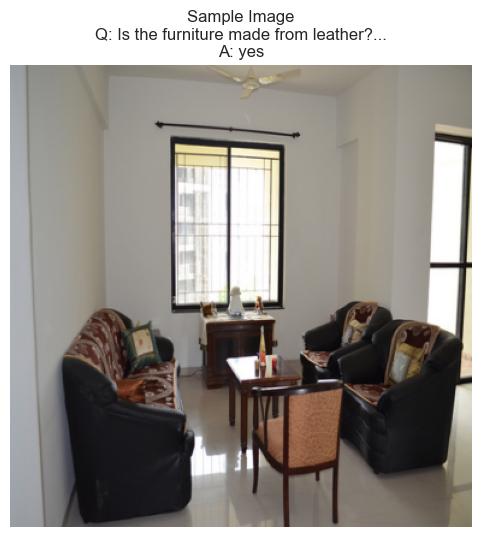


Dataset Statistics:
  Unique question types: 65
  Unique answer types: 3
  Average answer length: 1.11 words
  Min answer length: 1 words
  Max answer length: 18 words

Creating validation dataset:
 All 15571 images available
  Final validation samples: 15571

Quick validation test:
  First sample - Q: What time does the clock show?...
  First sample - A: 10:05
Validation dataset ready

DATASET CREATION COMPLETE
Training Dataset: 49330 samples
Validation Dataset: 15571 samples

GPU Memory Usage:
  Allocated: 0.00 GB
  Reserved: 0.00 GB


In [10]:
image_base_path = "VQA_Project_10k"  


# Create datasets with validated mappings
if train_split_df is not None and len(train_split_df) > 0:
    print(f"\nCreating training dataset:")
    train_dataset = VQADataset(
        train_split_df, 
        image_base_path, 
        split='train',
        image_id_map=train_image_map
    )
    print(f"  Final training samples: {len(train_dataset)}")
    
    # Test random samples with actual verification
    print(f"\nTesting random samples:")
    test_indices = np.random.choice(len(train_dataset), min(10, len(train_dataset)), replace=False)
    
    found_images = 0
    dummy_images = 0
    
    for i, idx in enumerate(test_indices):
        sample = train_dataset[idx]
        image_id = sample['image_id']
        question = sample['question'][:40] + "..." if len(sample['question']) > 40 else sample['question']
        answer = sample['answer']
        
        # Check if it's a real image or dummy
        image_tensor = sample['image']
        unique_values = torch.unique(image_tensor)
        
        print(f" Sample {i+1}:")
        print(f" Image ID: {image_id}")
        print(f" Question: {question}")
        print(f" Answer: {answer}")
        print(f" Image shape: {image_tensor.shape}")
        
        if len(unique_values) <= 3:  # Dummy image (uniform color)
            print(f"Status:  Dummy Image (image not found)")
            dummy_images += 1
        else:
            print(f"Status: REAL IMAGE")
            found_images += 1
        
        # Show actual image path if available
        if image_id in train_image_map:
            img_path = train_image_map[image_id]
            print(f"Path: {img_path.name[:30]}...")
        else:
            print(f" Path: Not Found in Mapping")
        
        print()
    
    # Summary of test results
    print(f"\nTest Summary for Training Dataset:")
    print(f"  Total samples tested: {len(test_indices)}")
    print(f"  Real images found: {found_images}")
    print(f"  Dummy images: {dummy_images}")
    
    if dummy_images > 0:
        print(f" Warning: {dummy_images} samples have dummy images")
        print(f"  Check your image mapping for missing files")
    
    # Test a single sample in detail
    print(f"\nDetailed inspection of first sample:")
    if len(train_dataset) > 0:
        sample = train_dataset[0]
        print(f"  Question: {sample['question']}")
        print(f"  Answer: {sample['answer']}")
        print(f"  Question type: {sample.get('question_type', 'N/A')}")
        print(f"  Image ID: {sample['image_id']}")
        print(f"  Question ID: {sample['question_id']}")
        
        # Visualize the image
        image_tensor = sample['image']
        image_np = image_tensor.numpy()
        image_np = image_np * 0.5 + 0.5  # Denormalize
        image_np = np.clip(image_np, 0, 1)
        image_np = image_np.transpose(1, 2, 0)
        
        plt.figure(figsize=(8, 6))
        plt.imshow(image_np)
        plt.title(f"Sample Image\nQ: {sample['question'][:50]}...\nA: {sample['answer']}")
        plt.axis('off')
        plt.show()
        
        # Check for data distribution
        print(f"\nDataset Statistics:")
        print(f"  Unique question types: {train_split_df['question_type'].nunique() if 'question_type' in train_split_df.columns else 'N/A'}")
        print(f"  Unique answer types: {train_split_df['answer_type'].nunique() if 'answer_type' in train_split_df.columns else 'N/A'}")
        
        # Check answer length distribution
        answer_lengths = train_split_df['multiple_choice_answer'].apply(lambda x: len(str(x).split()))
        print(f"  Average answer length: {answer_lengths.mean():.2f} words")
        print(f"  Min answer length: {answer_lengths.min()} words")
        print(f"  Max answer length: {answer_lengths.max()} words")
else:
    print("No training data available")

# Repeat for validation dataset
if val_split_df is not None and len(val_split_df) > 0:
    print(f"\n{'='*60}")
    print(f"Creating validation dataset:")
    val_dataset = VQADataset(
        val_split_df, 
        image_base_path, 
        split='val',
        image_id_map=val_image_map
    )
    print(f"  Final validation samples: {len(val_dataset)}")
    
    # Quick validation test
    print(f"\nQuick validation test:")
    if len(val_dataset) > 0:
        sample = val_dataset[0]
        print(f"  First sample - Q: {sample['question'][:50]}...")
        print(f"  First sample - A: {sample['answer']}")
        print(f"Validation dataset ready")
else:
    print("No validation data available")

# Final dataset summary
print(f"\n{'='*60}")
print("DATASET CREATION COMPLETE")
print("="*60)
if train_dataset is not None:
    print(f"Training Dataset: {len(train_dataset)} samples")
if val_dataset is not None:
    print(f"Validation Dataset: {len(val_dataset)} samples")

# Memory usage check
if torch.cuda.is_available():
    memory_allocated = torch.cuda.memory_allocated() / 1e9
    memory_reserved = torch.cuda.memory_reserved() / 1e9
    print(f"\nGPU Memory Usage:")
    print(f"  Allocated: {memory_allocated:.2f} GB")
    print(f"  Reserved: {memory_reserved:.2f} GB")

8. Creating data loaders

In [11]:
BATCH_SIZE = 8

# Create data loaders
train_loader = None
val_loader = None

if train_dataset is not None:
    train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=0,  # Set to 0 for Windows compatibility
        pin_memory=True if torch.cuda.is_available() else False,
        drop_last=True  # Drop last incomplete batch
    )
    print(f" Training DataLoader created: {len(train_loader)} batches")
    
    # Test the DataLoader
    try:
        test_batch = next(iter(train_loader))
        print(f" DataLoader test successful")
        print(f" Batch size: {test_batch['image'].shape[0]}")
        print(f" Image shape: {test_batch['image'].shape}")
        print(f" Sample question: {test_batch['question'][0][:50]}...")
    except Exception as e:
        print(f" DataLoader test failed: {e}")

if val_dataset is not None:
    val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=0,
        pin_memory=True if torch.cuda.is_available() else False
    )
    print(f" Validation DataLoader created: {len(val_loader)} batches")

 Training DataLoader created: 6166 batches
 DataLoader test successful
 Batch size: 8
 Image shape: torch.Size([8, 3, 384, 384])
 Sample question: Can you see any people?...
 Validation DataLoader created: 1947 batches


9. Test DataLoader

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.



Initializing BLIP-2 processor for compatibility test...
BLIP-2 processor loaded

Training DataLoader Test Results:
 Batch successfully loaded
 Batch size: 8
 Image shape: torch.Size([8, 3, 384, 384])

  Testing BLIP-2 compatibility:


It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


  Processor test successful
  Input keys: ['input_ids', 'attention_mask', 'pixel_values']
  Pixel values shape: torch.Size([1, 3, 224, 224])
  Input IDs shape: torch.Size([1, 43])


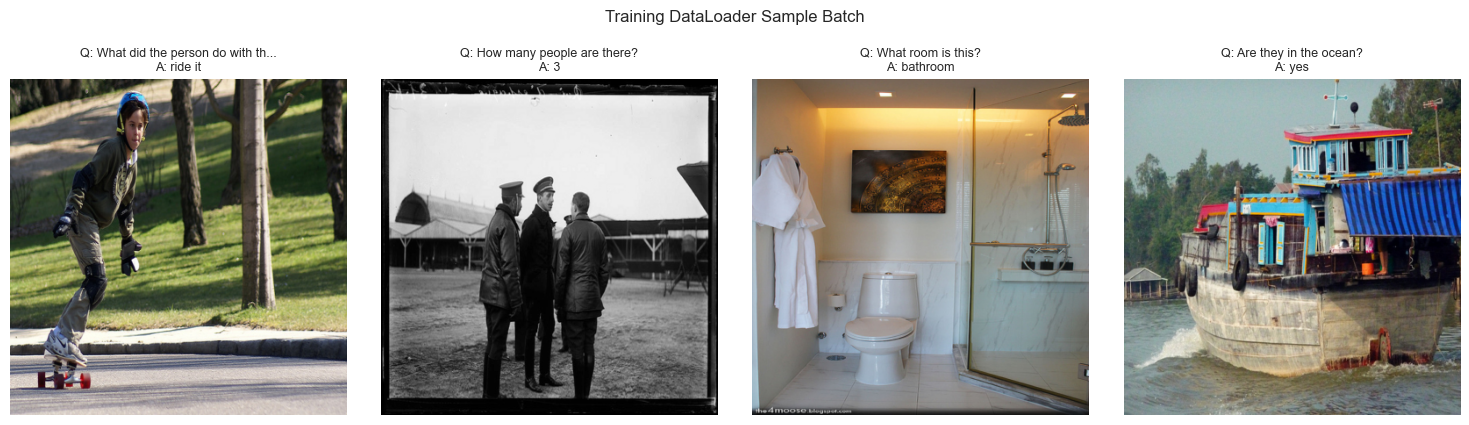

In [12]:
def test_dataloader_compatibility(dataloader, processor=None, name="DataLoader"):
    if dataloader is None:
        print(f" {name} is None")
        return False
    
    try:
        # Get one batch
        batch = next(iter(dataloader))
        
        print(f"\n{name} Test Results:")
        print(f" Batch successfully loaded")
        print(f" Batch size: {batch['image'].shape[0]}")
        print(f" Image shape: {batch['image'].shape}")
        
        # Check BLIP-2 compatibility if processor provided
        if processor is not None:
            print(f"\n  Testing BLIP-2 compatibility:")
            sample_question = batch['question'][0]
            sample_image = batch['image'][0]
            
            # Denormalize for processor
            sample_image_denorm = sample_image * 0.5 + 0.5
            
            # Test processor
            inputs = processor(
                images=sample_image_denorm.unsqueeze(0),
                text=sample_question,
                return_tensors="pt",
                padding=True
            )
            print(f"  Processor test successful")
            print(f"  Input keys: {list(inputs.keys())}")
            print(f"  Pixel values shape: {inputs['pixel_values'].shape}")
            print(f"  Input IDs shape: {inputs['input_ids'].shape}")
        
        # Visualize samples
        images = batch['image']
        questions = batch['question']
        answers = batch['answer']
        
        fig, axes = plt.subplots(1, min(4, len(images)), figsize=(15, 4))
        if min(4, len(images)) == 1:
            axes = [axes]
        
        for i in range(min(4, len(images))):
            img = images[i].numpy()
            img = img * 0.5 + 0.5
            img = np.clip(img, 0, 1)
            img = img.transpose(1, 2, 0)
            
            axes[i].imshow(img)
            
            q = questions[i][:30] + "..." if len(questions[i]) > 30 else questions[i]
            a = answers[i][:20] + "..." if len(answers[i]) > 20 else answers[i]
            
            axes[i].set_title(f"Q: {q}\nA: {a}", fontsize=9)
            axes[i].axis('off')
        
        plt.suptitle(f"{name} Sample Batch", fontsize=12, y=1.05)
        plt.tight_layout()
        plt.show()
        
        return True
        
    except Exception as e:
        print(f"  ✗ {name} test failed: {e}")
        return False

# Test with BLIP-2 processor
print("\nInitializing BLIP-2 processor for compatibility test...")
try:
    processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
    print("BLIP-2 processor loaded")
except:
    processor = None
    print("Could not load BLIP-2 processor, skipping compatibility test")

# Test DataLoader
if train_loader is not None:
    test_dataloader_compatibility(train_loader, processor, "Training DataLoader")

Phase 2: EDA

Create DataFrame for EDA Analysis

In [13]:
def create_dataframe_from_dataset(dataset_split, split_name='train'):
    if dataset_split is None:
        return None
    
    questions = dataset_split['questions']['questions']
    annotations = dataset_split['annotations']['annotations']
    
    # Create dictionaries for quick lookup
    question_dict = {q['question_id']: q for q in questions}
    annotation_dict = {a['question_id']: a for a in annotations}
    
    # Prepare data for DataFrame
    data = []
    for qid, question in question_dict.items():
        if qid in annotation_dict:
            annotation = annotation_dict[qid]
            data.append({
                'question_id': qid,
                'image_id': question['image_id'],
                'question': question['question'],
                'question_type': annotation.get('question_type', 'unknown'),
                'answer_type': annotation.get('answer_type', 'unknown'),
                'multiple_choice_answer': annotation.get('multiple_choice_answer', ''),
                'answers': [ans['answer'] for ans in annotation.get('answers', [])],
                'answer_confidence': annotation.get('answer_confidence', 'yes')
            })
    
    df = pd.DataFrame(data)
    df['split'] = split_name
    return df

# Create DataFrames
train_df = create_dataframe_from_dataset(dataset.get('train'), 'train')
val_df = create_dataframe_from_dataset(dataset.get('val'), 'val')

if train_df is not None:
    print(f"Train DataFrame shape: {train_df.shape}")
    print("\nFirst few rows:")
    print(train_df.head())

Train DataFrame shape: (49760, 9)

First few rows:
   question_id  image_id                                           question  \
0    131074000    131074                             What is on the pillow?   
1    131074001    131074  How many pieces of furniture which are used fo...   
2    131074002    131074             Are the walls done in a summery color?   
3    131074003    131074                          Is the curtain patterned?   
4    131074004    131074                      What is sitting on the bench?   

    question_type answer_type multiple_choice_answer  \
0  what is on the       other                   gray   
1        how many      number                      2   
2         are the      yes/no                    yes   
3          is the      yes/no                     no   
4         what is       other                  purse   

                                             answers answer_confidence  split  
0  [pillow sham, frills, pillow case, pillowcases...     

Phase 3

EDA1: Question Type Frequency Analysis

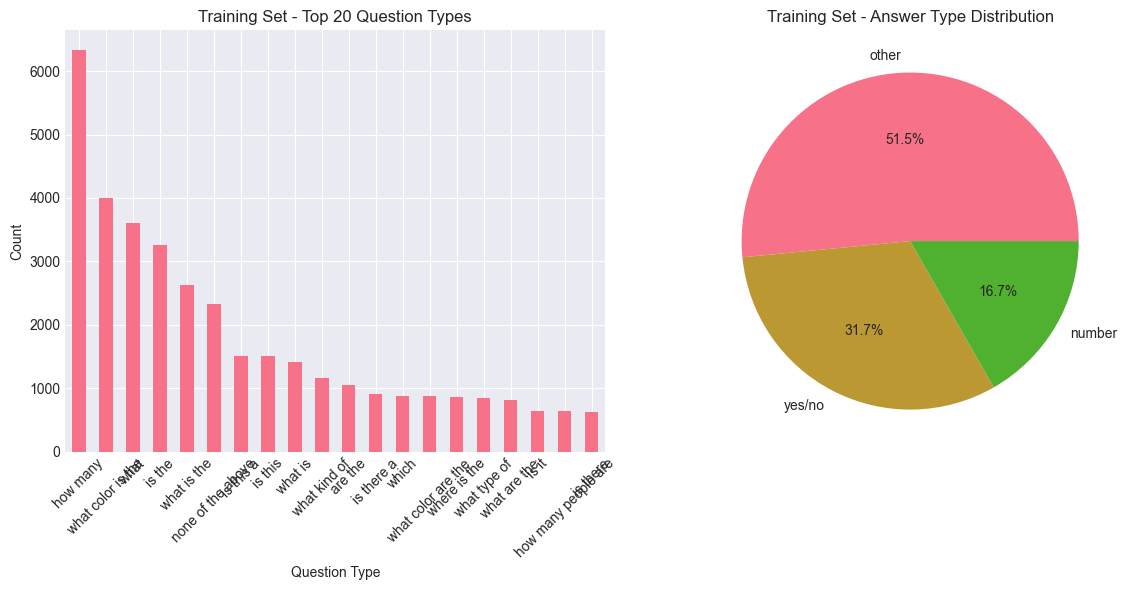

Total unique question types: 65

Top 10 question types:
1. how many: 6325 (12.7%)
2. what color is the: 4004 (8.0%)
3. what: 3608 (7.3%)
4. is the: 3253 (6.5%)
5. what is the: 2626 (5.3%)
6. none of the above: 2330 (4.7%)
7. is this a: 1513 (3.0%)
8. is this: 1511 (3.0%)
9. what is: 1414 (2.8%)
10. what kind of: 1170 (2.4%)

Most common question starters:
  what: 20779
  is: 10485
  how: 7863
  are: 3174
  where: 1665
  does: 1063
  which: 878
  why: 664
  who: 570
  do: 484


In [14]:
def analyze_question_types(df, title_prefix=""):
    if df is None:
        print("No data available for analysis")
        return
    
    plt.figure(figsize=(12, 6))
    
    # Get question type distribution
    question_type_counts = df['question_type'].value_counts()
    
    # Plot
    ax1 = plt.subplot(1, 2, 1)
    question_type_counts.head(20).plot(kind='bar', ax=ax1)
    ax1.set_title(f'{title_prefix}Top 20 Question Types')
    ax1.set_xlabel('Question Type')
    ax1.set_ylabel('Count')
    ax1.tick_params(axis='x', rotation=45)
    
    # Answer type distribution
    ax2 = plt.subplot(1, 2, 2)
    answer_type_counts = df['answer_type'].value_counts()
    answer_type_counts.plot(kind='pie', ax=ax2, autopct='%1.1f%%')
    ax2.set_title(f'{title_prefix}Answer Type Distribution')
    ax2.set_ylabel('')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print(f"Total unique question types: {len(question_type_counts)}")
    print(f"\nTop 10 question types:")
    for i, (qtype, count) in enumerate(question_type_counts.head(10).items(), 1):
        percentage = (count / len(df)) * 100
        print(f"{i}. {qtype}: {count} ({percentage:.1f}%)")
    
    # Analyze question starters
    question_starters = df['question'].apply(lambda x: x.split()[0].lower())
    starter_counts = Counter(question_starters)
    print(f"\nMost common question starters:")
    for starter, count in starter_counts.most_common(10):
        print(f"  {starter}: {count}")
    
    return question_type_counts

# Analyze train data
if train_df is not None:
    train_qtypes = analyze_question_types(train_df, "Training Set - ")

EDA 2: Answer Frequency and Long-Tail Distribution

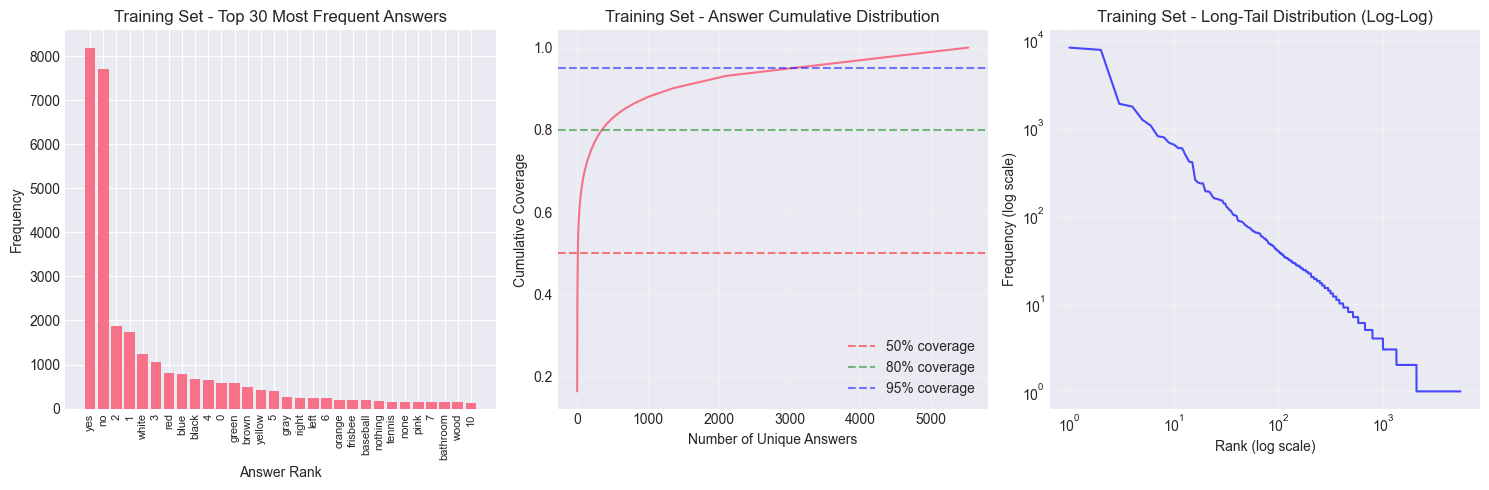

Total answers: 49760
Unique answers: 5527
Vocabulary coverage by top answers:
  Top   10 answers cover 49.6% of all answers
  Top   50 answers cover 64.0% of all answers
  Top  100 answers cover 69.5% of all answers
  Top  500 answers cover 82.9% of all answers
  Top 1000 answers cover 88.0% of all answers

Zipf's law indicators:
  Most common answer: 'yes' appears 8174 times
  Ratio 1st/2nd: 1.1
  Ratio 1st/10th: 12.7


In [15]:
def analyze_answer_distribution(df, title_prefix=""):
    if df is None:
        print("No data available for analysis")
        return
    
    # Get all answers (from multiple_choice_answer)
    all_answers = df['multiple_choice_answer'].dropna().str.lower().tolist()
    answer_counts = Counter(all_answers)
    
    # Sort by frequency
    sorted_counts = sorted(answer_counts.items(), key=lambda x: x[1], reverse=True)
    answers_sorted = [item[0] for item in sorted_counts]
    counts_sorted = [item[1] for item in sorted_counts]
    
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Top answers
    ax1 = plt.subplot(1, 3, 1)
    top_n = 30
    ax1.bar(range(top_n), counts_sorted[:top_n])
    ax1.set_title(f'{title_prefix}Top {top_n} Most Frequent Answers')
    ax1.set_xlabel('Answer Rank')
    ax1.set_ylabel('Frequency')
    ax1.set_xticks(range(top_n))
    ax1.set_xticklabels(answers_sorted[:top_n], rotation=90, fontsize=8)
    
    # Plot 2: Cumulative distribution
    ax2 = plt.subplot(1, 3, 2)
    cumulative_sum = np.cumsum(counts_sorted) / np.sum(counts_sorted)
    ax2.plot(range(1, len(cumulative_sum) + 1), cumulative_sum)
    ax2.axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='50% coverage')
    ax2.axhline(y=0.8, color='g', linestyle='--', alpha=0.5, label='80% coverage')
    ax2.axhline(y=0.95, color='b', linestyle='--', alpha=0.5, label='95% coverage')
    ax2.set_title(f'{title_prefix}Answer Cumulative Distribution')
    ax2.set_xlabel('Number of Unique Answers')
    ax2.set_ylabel('Cumulative Coverage')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Long-tail visualization
    ax3 = plt.subplot(1, 3, 3)
    ax3.loglog(range(1, len(counts_sorted) + 1), counts_sorted, 'b-', alpha=0.7)
    ax3.set_title(f'{title_prefix}Long-Tail Distribution (Log-Log)')
    ax3.set_xlabel('Rank (log scale)')
    ax3.set_ylabel('Frequency (log scale)')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    total_answers = len(all_answers)
    unique_answers = len(answer_counts)
    print(f"Total answers: {total_answers}")
    print(f"Unique answers: {unique_answers}")
    print(f"Vocabulary coverage by top answers:")
    
    coverage_points = [10, 50, 100, 500, 1000]
    for n in coverage_points:
        if n <= unique_answers:
            coverage = sum(counts_sorted[:n]) / total_answers * 100
            print(f"  Top {n:4d} answers cover {coverage:.1f}% of all answers")
    
    # Zipf's law analysis
    print(f"\nZipf's law indicators:")
    print(f"  Most common answer: '{answers_sorted[0]}' appears {counts_sorted[0]} times")
    print(f"  Ratio 1st/2nd: {counts_sorted[0]/counts_sorted[1]:.1f}")
    print(f"  Ratio 1st/10th: {counts_sorted[0]/counts_sorted[9]:.1f}")
    
    return answer_counts

# Analyze answer distribution
if train_df is not None:
    answer_counts = analyze_answer_distribution(train_df, "Training Set - ")

EDA 3: Answer Variability and Annotator Agreement

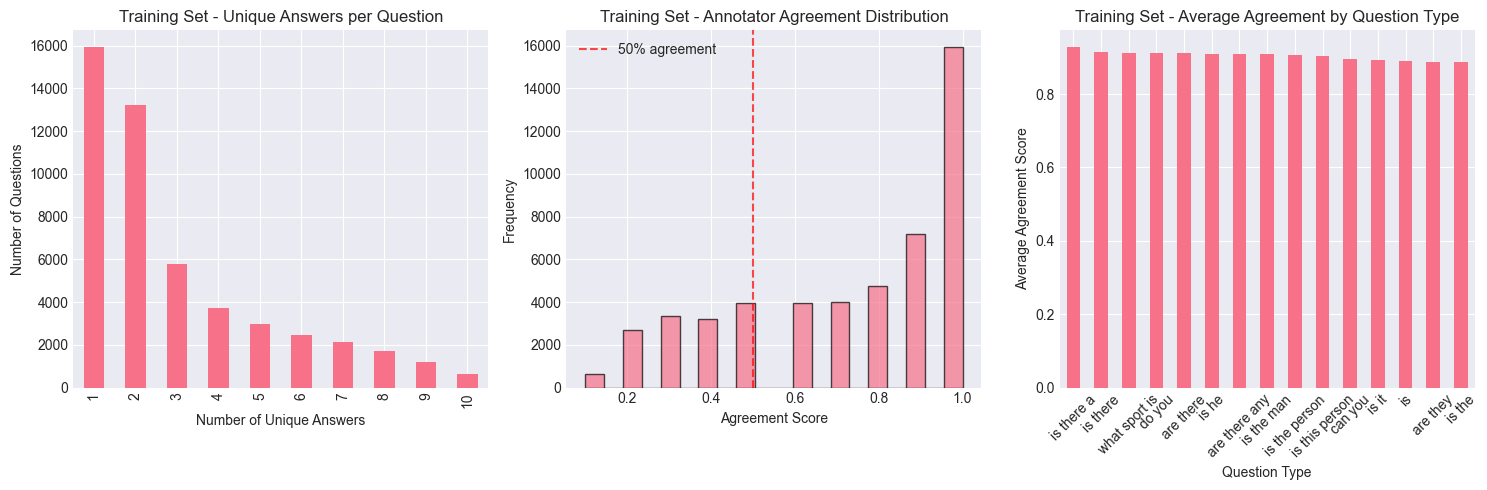

Answer Variability Statistics:
Average number of answers per question: 10.00
Average number of unique answers per question: 3.01
Average agreement score: 0.729

Questions with perfect agreement: 15915 (32.0%)
Questions with low agreement (<0.5): 9952 (20.0%)

Examples of high agreement questions (>0.8):
  Q: How many pieces of furniture which are used for sleeping are featured in this picture?
  Answers: ['2', '2', '2', '2', '2', '2', '2', '2', '2', '2']
  Agreement: 1.00

  Q: What is sitting on the bench?
  Answers: ['purse', 'purse', 'purse', 'handbag', 'purse', 'purse', 'purse', 'purse', 'purse', 'purse']
  Agreement: 0.90

  Q: Are there flowers in the vase?
  Answers: ['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes']
  Agreement: 1.00



In [16]:
def analyze_answer_variability(df, title_prefix=""):
    if df is None:
        print("No data available for analysis")
        return
    
    # Calculate agreement metrics
    agreement_metrics = []
    
    for _, row in df.iterrows():
        answers = row['answers']
        if not isinstance(answers, list) or len(answers) == 0:
            continue
        
        # Count unique answers
        unique_answers = set(answers)
        num_answers = len(answers)
        num_unique = len(unique_answers)
        
        # Calculate agreement score
        if num_answers > 1:
            # Most common answer frequency
            most_common_count = max(Counter(answers).values())
            agreement_score = most_common_count / num_answers
        else:
            agreement_score = 1.0
        
        agreement_metrics.append({
            'question_id': row['question_id'],
            'num_answers': num_answers,
            'num_unique_answers': num_unique,
            'agreement_score': agreement_score,
            'question_type': row['question_type']
        })
    
    agreement_df = pd.DataFrame(agreement_metrics)
    
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Distribution of unique answers per question
    ax1 = plt.subplot(1, 3, 1)
    unique_counts = agreement_df['num_unique_answers'].value_counts().sort_index()
    unique_counts.plot(kind='bar', ax=ax1)
    ax1.set_title(f'{title_prefix}Unique Answers per Question')
    ax1.set_xlabel('Number of Unique Answers')
    ax1.set_ylabel('Number of Questions')
    
    # Plot 2: Agreement score distribution
    ax2 = plt.subplot(1, 3, 2)
    ax2.hist(agreement_df['agreement_score'], bins=20, edgecolor='black', alpha=0.7)
    ax2.axvline(x=0.5, color='r', linestyle='--', alpha=0.7, label='50% agreement')
    ax2.set_title(f'{title_prefix}Annotator Agreement Distribution')
    ax2.set_xlabel('Agreement Score')
    ax2.set_ylabel('Frequency')
    ax2.legend()
    
    # Plot 3: Agreement by question type
    ax3 = plt.subplot(1, 3, 3)
    agreement_by_type = agreement_df.groupby('question_type')['agreement_score'].mean().sort_values(ascending=False)
    agreement_by_type.head(15).plot(kind='bar', ax=ax3)
    ax3.set_title(f'{title_prefix}Average Agreement by Question Type')
    ax3.set_xlabel('Question Type')
    ax3.set_ylabel('Average Agreement Score')
    ax3.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("Answer Variability Statistics:")
    print(f"Average number of answers per question: {agreement_df['num_answers'].mean():.2f}")
    print(f"Average number of unique answers per question: {agreement_df['num_unique_answers'].mean():.2f}")
    print(f"Average agreement score: {agreement_df['agreement_score'].mean():.3f}")
    
    print(f"\nQuestions with perfect agreement: "
          f"{(agreement_df['agreement_score'] == 1.0).sum()} "
          f"({(agreement_df['agreement_score'] == 1.0).mean()*100:.1f}%)")
    
    print(f"Questions with low agreement (<0.5): "
          f"{(agreement_df['agreement_score'] < 0.5).sum()} "
          f"({(agreement_df['agreement_score'] < 0.5).mean()*100:.1f}%)")
    
    # Show examples of high and low agreement
    print("\nExamples of high agreement questions (>0.8):")
    high_agreement = agreement_df[agreement_df['agreement_score'] > 0.8].head(3)
    for idx, row in high_agreement.iterrows():
        qid = row['question_id']
        original_row = df[df['question_id'] == qid].iloc[0]
        print(f"  Q: {original_row['question']}")
        print(f"  Answers: {original_row['answers']}")
        print(f"  Agreement: {row['agreement_score']:.2f}\n")
    
    return agreement_df

# Analyze answer variability
if train_df is not None:
    agreement_df = analyze_answer_variability(train_df, "Training Set - ")

EDA 4: Qualitative Multimodal Examples

Running Qualitative Multimodal Examples Analysis:
Attempting to display 3 examples from 49330 total samples
Found images at: VQA_Project\train_images


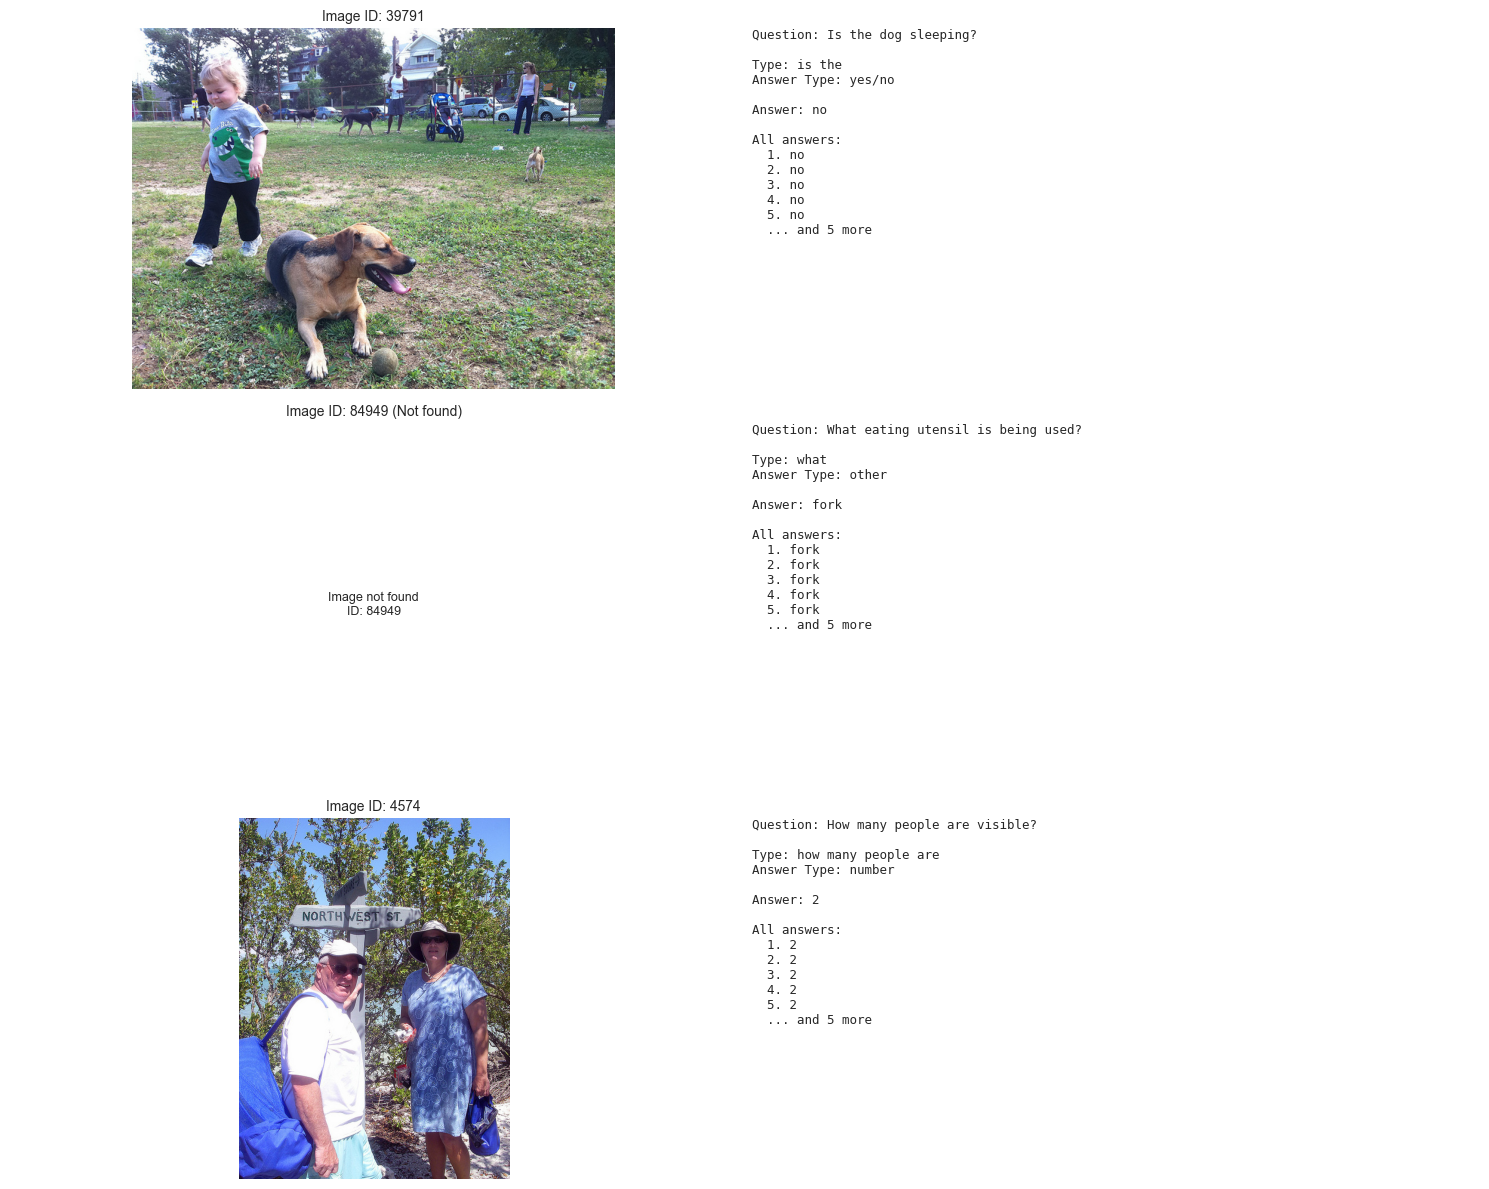

Qualitative Analysis Summary
Images found and displayed: 2/3
Success rate: 66.7%

Sample Questions Displayed:
1. [Image Found] Image 39791: Is the dog sleeping?...
2. [Image Not Found] Image 84949: What eating utensil is being used?...
3. [Image Found] Image 4574: How many people are visible?...

Dataset Insights:
- Total samples: 49330
- Questions with complex reasoning (why/how/what is): 25
- Questions with simple binary form (is/are/does): 97
- Counting questions: 7611
- Color-related questions: 6557


In [17]:
def display_multimodal_examples(df, image_base_path, num_examples=5):
    if df is None or len(df) == 0:
        print("No data available for display")
        return []
    
    print(f"Attempting to display {num_examples} examples from {len(df)} total samples")
    
    # Try to find the image directory
    base_path = Path(image_base_path)
    
    # Check for train_images directory in various locations
    possible_paths = [
        base_path / 'train_images',
        base_path / 'val_images',
        base_path.parent / 'train_images',
        base_path.parent / 'val_images',
        Path('train_images'),
        Path('val_images'),
        Path('VQA_Project_10k/train_images'),
        Path('VQA_Project_10k/val_images'),
        Path('../train_images'),
        Path('../val_images'),
    ]
    
    image_path = None
    for path in possible_paths:
        if path.exists():
            image_path = path
            print(f"Found images at: {image_path}")
            break
    
    if image_path is None:
        print(f"Warning: Could not find image folder. Checked:")
        for path in possible_paths:
            print(f"  - {path}")
        print("Will display text only.")
    
    # Get random examples
    if len(df) < num_examples:
        num_examples = len(df)
    
    sample_indices = np.random.choice(len(df), num_examples, replace=False)
    
    fig, axes = plt.subplots(num_examples, 2, figsize=(15, 4 * num_examples))
    
    if num_examples == 1:
        axes = axes.reshape(1, 2)
    
    examples_displayed = []
    images_found = 0
    
    for i, idx in enumerate(sample_indices):
        row = df.iloc[idx]
        image_id = row['image_id']
        question = row['question']
        
        # Image display (left column)
        img_ax = axes[i, 0] if num_examples > 1 else axes[0]
        
        if image_path and image_path.exists():
            # Try to find the image file
            image_file = None
            
            # Try different naming patterns
            patterns_to_try = [
                # COCO format with 12-digit padding
                f"COCO_train2014_{int(image_id):012d}.jpg",
                f"COCO_val2014_{int(image_id):012d}.jpg",
                # Without padding
                f"COCO_train2014_{image_id}.jpg",
                f"COCO_val2014_{image_id}.jpg",
                # Just the ID
                f"{int(image_id):012d}.jpg",
                f"{image_id}.jpg",
                # Try any file containing the ID
                f"*{image_id}*.jpg",
                f"*{image_id}*.png",
                f"*{int(image_id)}*.jpg",
                f"*{int(image_id)}*.png",
            ]
            
            for pattern in patterns_to_try:
                if '*' in pattern:
                    matches = list(image_path.glob(pattern))
                    if matches:
                        image_file = matches[0]
                        break
                else:
                    potential_file = image_path / pattern
                    if potential_file.exists():
                        image_file = potential_file
                        break
            
            if image_file and image_file.exists():
                try:
                    img = Image.open(image_file)
                    img_ax.imshow(img)
                    img_ax.set_title(f"Image ID: {image_id}", fontsize=10)
                    images_found += 1
                    examples_displayed.append({
                        'image_id': image_id,
                        'image_found': True,
                        'question': question
                    })
                except Exception as e:
                    img_ax.text(0.5, 0.5, f"Error loading\n{image_file.name[:20]}...", 
                               ha='center', va='center', fontsize=9)
                    img_ax.set_title(f"Image ID: {image_id} (Error)", fontsize=10)
                    examples_displayed.append({
                        'image_id': image_id,
                        'image_found': False,
                        'error': str(e)[:50],
                        'question': question
                    })
            else:
                # Show placeholder
                img_ax.text(0.5, 0.5, f"Image not found\nID: {image_id}", 
                           ha='center', va='center', fontsize=9)
                img_ax.set_title(f"Image ID: {image_id} (Not found)", fontsize=10)
                examples_displayed.append({
                    'image_id': image_id,
                    'image_found': False,
                    'question': question
                })
        else:
            # No image path
            img_ax.text(0.5, 0.5, f"No image folder\nImage ID: {image_id}", 
                       ha='center', va='center', fontsize=9)
            img_ax.set_title(f"Image ID: {image_id}", fontsize=10)
            examples_displayed.append({
                'image_id': image_id,
                'image_found': False,
                'question': question
            })
        
        img_ax.axis('off')
        
        # Text display (right column)
        text_ax = axes[i, 1] if num_examples > 1 else axes[1]
        text_ax.axis('off')
        
        # Prepare text content
        text_content = []
        text_content.append(f"Question: {question}")
        text_content.append("")
        
        if 'question_type' in row:
            text_content.append(f"Type: {row['question_type']}")
        if 'answer_type' in row:
            text_content.append(f"Answer Type: {row['answer_type']}")
        
        text_content.append("")
        
        if 'multiple_choice_answer' in row:
            text_content.append(f"Answer: {row['multiple_choice_answer']}")
        
        text_content.append("")
        text_content.append("All answers:")
        
        # Display up to 5 answers
        answers = row.get('answers', [])
        if isinstance(answers, list) and answers:
            for j, ans in enumerate(answers[:5], 1):
                text_content.append(f"  {j}. {ans}")
            if len(answers) > 5:
                text_content.append(f"  ... and {len(answers)-5} more")
        else:
            text_content.append("  No answers available")
        
        # Display text
        text_ax.text(0, 1, '\n'.join(text_content), 
                    fontsize=9, va='top', family='monospace',
                    transform=text_ax.transAxes)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("Qualitative Analysis Summary")
    print(f"Images found and displayed: {images_found}/{num_examples}")
    print(f"Success rate: {images_found/num_examples*100:.1f}%")
    
    # Print detailed examples
    print(f"\nSample Questions Displayed:")
    for i, example in enumerate(examples_displayed, 1):
        status = "Image Found" if example.get('image_found', False) else "Image Not Found"
        print(f"{i}. [{status}] Image {example['image_id']}: {example['question'][:50]}...")
    
    # Additional insights
    if len(df) > 0:
        print(f"\nDataset Insights:")
        print(f"- Total samples: {len(df)}")
        
        # Check question complexity
        complex_keywords = ['why', 'how', 'what is', 'describe', 'explain', 'what are']
        simple_keywords = ['is', 'are', 'do', 'does', 'can', 'has', 'have']
        
        complex_count = 0
        simple_count = 0
        
        for q in df['question'].head(100):  # Check first 100 for efficiency
            q_lower = str(q).lower()
            if any(keyword in q_lower for keyword in complex_keywords):
                complex_count += 1
            if any(keyword in q_lower for keyword in simple_keywords):
                simple_count += 1
        
        print(f"- Questions with complex reasoning (why/how/what is): {complex_count}")
        print(f"- Questions with simple binary form (is/are/does): {simple_count}")
        
        # Check for counting questions
        counting_questions = df['question'].str.contains('many|much|count', case=False, na=False).sum()
        print(f"- Counting questions: {counting_questions}")
        
        # Check for color questions
        color_questions = df['question'].str.contains('color|colour', case=False, na=False).sum()
        print(f"- Color-related questions: {color_questions}")
    
    return examples_displayed

# Actually call the function
print("Running Qualitative Multimodal Examples Analysis:")
print("="*60)

# Use the train_split_df from Phase 1
if 'train_split_df' in locals() and train_split_df is not None:
    examples = display_multimodal_examples(train_split_df, image_base_path="VQA_Project", num_examples=3)
    
    if not examples:
        print("\nNo examples were displayed. Possible issues:")
        print("1. Check if train_split_df exists and has data")
        print("2. Verify the image_base_path points to your VQA_Project folder")
        print("3. Check if images are in train_images/ folder")
        
        # Debug: Show what's in train_split_df
        if train_split_df is not None:
            print(f"\nDebug - train_split_df info:")
            print(f"  Shape: {train_split_df.shape}")
            print(f"  Columns: {train_split_df.columns.tolist()}")
            print(f"  Sample image_id: {train_split_df['image_id'].iloc[0] if len(train_split_df) > 0 else 'N/A'}")
else:
    print("Error: train_split_df not found. Run Phase 1 code first.")
    
    # Try with train_df if it exists
    if 'train_df' in locals() and train_df is not None:
        print("Falling back to train_df:")
        examples = display_multimodal_examples(train_df, image_base_path="VQA_Project", num_examples=3)
    else:
        print("No training data available. Please run Phase 1 data loading first.")

EDA 5: Question Length Distribution

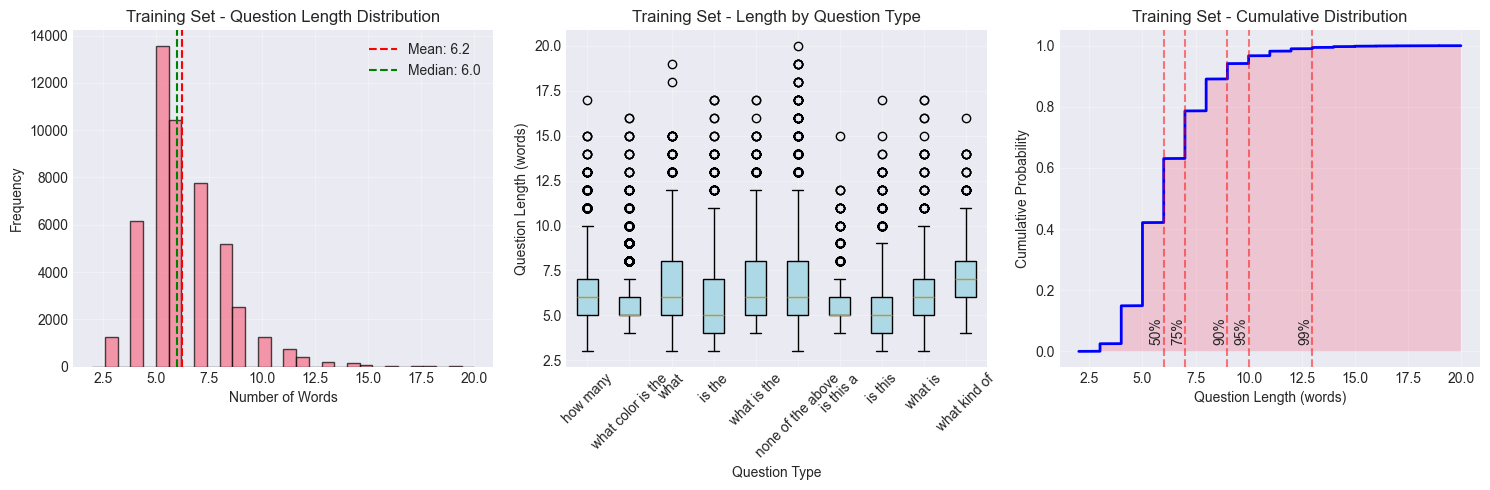

Question Length Statistics:
Mean length: 6.23 words
Median length: 6.00 words
Standard deviation: 1.93 words
Minimum length: 2 words
Maximum length: 20 words

Percentiles:
  25th percentile: 5.0 words
  50th percentile: 6.0 words
  75th percentile: 7.0 words
  90th percentile: 9.0 words
  95th percentile: 10.0 words
  99th percentile: 13.0 words

Percentage of questions with length <= 10: 96.7%
Percentage of questions with length <= 15: 99.8%
Percentage of questions with length <= 20: 100.0%

Average length by answer type:
  other: 6.4 words (n=25645)
  number: 6.5 words (n=8327)
  yes/no: 5.8 words (n=15788)


In [18]:
def analyze_question_length(df, title_prefix=""):
    """Analyze distribution of question lengths"""
    if df is None:
        print("No data available for analysis")
        return
    
    # Calculate question lengths
    df['question_length'] = df['question'].apply(lambda x: len(str(x).split()))
    
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Histogram of question lengths
    ax1 = plt.subplot(1, 3, 1)
    ax1.hist(df['question_length'], bins=30, edgecolor='black', alpha=0.7)
    ax1.axvline(x=df['question_length'].mean(), color='r', linestyle='--', 
               label=f'Mean: {df["question_length"].mean():.1f}')
    ax1.axvline(x=df['question_length'].median(), color='g', linestyle='--', 
               label=f'Median: {df["question_length"].median():.1f}')
    ax1.set_title(f'{title_prefix}Question Length Distribution')
    ax1.set_xlabel('Number of Words')
    ax1.set_ylabel('Frequency')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Box plot by question type
    ax2 = plt.subplot(1, 3, 2)
    top_qtypes = df['question_type'].value_counts().head(10).index
    subset = df[df['question_type'].isin(top_qtypes)]
    
    # Create box plot data
    box_data = []
    labels = []
    for qtype in top_qtypes:
        lengths = subset[subset['question_type'] == qtype]['question_length']
        if len(lengths) > 0:
            box_data.append(lengths)
            labels.append(qtype)
    
    bp = ax2.boxplot(box_data, labels=labels, patch_artist=True)
    for patch in bp['boxes']:
        patch.set_facecolor('lightblue')
    
    ax2.set_title(f'{title_prefix}Length by Question Type')
    ax2.set_xlabel('Question Type')
    ax2.set_ylabel('Question Length (words)')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: Cumulative distribution
    ax3 = plt.subplot(1, 3, 3)
    sorted_lengths = np.sort(df['question_length'])
    cumulative = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths)
    
    ax3.plot(sorted_lengths, cumulative, 'b-', linewidth=2)
    ax3.fill_between(sorted_lengths, 0, cumulative, alpha=0.3)
    
    # Mark percentiles
    percentiles = [50, 75, 90, 95, 99]
    for p in percentiles:
        value = np.percentile(df['question_length'], p)
        ax3.axvline(x=value, color='r', linestyle='--', alpha=0.5)
        ax3.text(value, 0.02, f'{p}%', rotation=90, va='bottom', ha='right')
    
    ax3.set_title(f'{title_prefix}Cumulative Distribution')
    ax3.set_xlabel('Question Length (words)')
    ax3.set_ylabel('Cumulative Probability')
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("Question Length Statistics:")
    print(f"Mean length: {df['question_length'].mean():.2f} words")
    print(f"Median length: {df['question_length'].median():.2f} words")
    print(f"Standard deviation: {df['question_length'].std():.2f} words")
    print(f"Minimum length: {df['question_length'].min()} words")
    print(f"Maximum length: {df['question_length'].max()} words")
    
    print(f"\nPercentiles:")
    for p in [25, 50, 75, 90, 95, 99]:
        value = np.percentile(df['question_length'], p)
        print(f"  {p}th percentile: {value:.1f} words")
    
    print(f"\nPercentage of questions with length <= 10: "
          f"{(df['question_length'] <= 10).mean()*100:.1f}%")
    print(f"Percentage of questions with length <= 15: "
          f"{(df['question_length'] <= 15).mean()*100:.1f}%")
    print(f"Percentage of questions with length <= 20: "
          f"{(df['question_length'] <= 20).mean()*100:.1f}%")
    
    # Correlation with answer type
    print(f"\nAverage length by answer type:")
    for atype in df['answer_type'].unique():
        avg_len = df[df['answer_type'] == atype]['question_length'].mean()
        count = (df['answer_type'] == atype).sum()
        print(f"  {atype}: {avg_len:.1f} words (n={count})")

# Analyze question length
if train_df is not None:
    analyze_question_length(train_df, "Training Set - ")

EDA Summary and Insights

In [19]:
def generate_eda_summary(df):
    if df is None:
        print("No data available for summary")
        return
    
    print("=" * 60)
    print("EDA SUMMARY AND INSIGHTS")
    print("=" * 60)
    
    # Basic statistics
    print(f"\n1. DATASET OVERVIEW:")
    print(f" Total questions: {len(df):,}")
    print(f" Unique images: {df['image_id'].nunique():,}")
    print(f" Unique question types: {df['question_type'].nunique()}")
    print(f" Unique answers: {df['multiple_choice_answer'].nunique():,}")
    
    # Question type insights
    print(f"\n2. QUESTION TYPE ANALYSIS:")
    top_qtype = df['question_type'].mode()[0]
    top_qtype_pct = (df['question_type'] == top_qtype).mean() * 100
    print(f"   Most common question type: '{top_qtype}' ({top_qtype_pct:.1f}%)")
    
    question_starters = df['question'].apply(lambda x: x.split()[0].lower())
    top_starter = Counter(question_starters).most_common(1)[0]
    print(f"   Most common question starter: '{top_starter[0]}' ({top_starter[1]} times)")
    
    # Answer distribution insights
    print(f"\n3. ANSWER DISTRIBUTION INSIGHTS:")
    answer_counts = Counter(df['multiple_choice_answer'].str.lower())
    top_answer = answer_counts.most_common(1)[0]
    top_10_coverage = sum(list(answer_counts.values())[:10]) / len(df) * 100
    top_100_coverage = sum(list(answer_counts.values())[:100]) / len(df) * 100
    
    print(f" Most common answer: '{top_answer[0]}' ({top_answer[1]} times)")
    print(f" Top 10 answers cover: {top_10_coverage:.1f}% of all answers")
    print(f" Top 100 answers cover: {top_100_coverage:.1f}% of all answers")
    print(f" Answers appearing only once: {sum(1 for v in answer_counts.values() if v == 1):,}")
    
    # Agreement insights
    print(f"\n4. ANNOTATOR AGREEMENT INSIGHTS:")
    if 'answers' in df.columns:
        perfect_agreement = sum(1 for ans_list in df['answers'] 
                               if isinstance(ans_list, list) and len(set(ans_list)) == 1)
        print(f"   Questions with perfect annotator agreement: {perfect_agreement:,}")
        print(f"   Percentage: {perfect_agreement/len(df)*100:.1f}%")
    
    # Question length insights
    print(f"\n5. QUESTION COMPLEXITY INSIGHTS:")
    df['question_length'] = df['question'].apply(lambda x: len(str(x).split()))
    print(f" Average question length: {df['question_length'].mean():.1f} words")
    print(f" Median question length: {df['question_length'].median():.1f} words")
    print(f" Questions with <= 5 words: {(df['question_length'] <= 5).mean()*100:.1f}%")
    print(f" Questions with <= 10 words: {(df['question_length'] <= 10).mean()*100:.1f}%")
    
    # Implications for model design
    print(f"\n6. IMPLICATIONS FOR GENERATIVE VQA MODEL:")
    print(f" Long-tail answer distribution → Requires generative approach")
    print(f" Variable annotator agreement → Soft evaluation metrics needed")
    print(f" Diverse question types → Multi-faceted reasoning required")
    print(f" Short questions → Focus on visual understanding over language")
    print(f" Multiple correct answers → Model should capture answer diversity")
    
    return {
        'total_questions': len(df),
        'unique_answers': df['multiple_choice_answer'].nunique(),
        'avg_question_length': df['question_length'].mean(),
        'top_answer_coverage': top_100_coverage
    }

# Generate summary
if train_df is not None:
    summary_stats = generate_eda_summary(train_df)

EDA SUMMARY AND INSIGHTS

1. DATASET OVERVIEW:
 Total questions: 49,760
 Unique images: 10,000
 Unique question types: 65
 Unique answers: 5,527

2. QUESTION TYPE ANALYSIS:
   Most common question type: 'how many' (12.7%)
   Most common question starter: 'what' (20779 times)

3. ANSWER DISTRIBUTION INSIGHTS:
 Most common answer: 'yes' (8174 times)
 Top 10 answers cover: 39.2% of all answers
 Top 100 answers cover: 57.1% of all answers
 Answers appearing only once: 3,432

4. ANNOTATOR AGREEMENT INSIGHTS:
   Questions with perfect annotator agreement: 15,915
   Percentage: 32.0%

5. QUESTION COMPLEXITY INSIGHTS:
 Average question length: 6.2 words
 Median question length: 6.0 words
 Questions with <= 5 words: 42.1%
 Questions with <= 10 words: 96.7%

6. IMPLICATIONS FOR GENERATIVE VQA MODEL:
 Long-tail answer distribution → Requires generative approach
 Variable annotator agreement → Soft evaluation metrics needed
 Diverse question types → Multi-faceted reasoning required
 Short question